<img src="https://raw.githubusercontent.com/YueJi95/temp/master/Festival_de_Cannes_logo.png">
<h1><center> Predicting 2018 Cannes Film Awards using Twitter Data</center></h1>

<div style="text-align: right;black">
Team Member:
<br>
Yanwen Lin: yanwenl
<br>
Minxuan Cao: minxuanc
<br>
Yue Ji: yji1
</div>

Can we predict film awards using Twitter data? At first, this may seem absurd. The winners of major film awards, such as the Oscar Movie Awards or the Cannes Film Awards, are chosen by a jury of established artists. They are unlikely to post all of their thoughts on Twitter. Would it be possible to predict one group of people’s mind using another group’s opinion?

Yes, indeed. Living in the era of social media, we are constantly influenced by other people’s opinion. Previous efforts in predicting the Oscar Movie Awards using Twitter data have been made by various parties, including Jenn Deering Davis (https://unionmetrics.com/blog/2011/01/using-tweets-to-predict-oscar-winners/), Paul Singman(https://github.com/peacing/OscarsPredictor), etc. 

Most of previous work only used classical statistics and natural language processing. Extending from these work, we aim to use machine learning techniques to predict the 2018 Cannes Film Awards winners. In the following report, we define a winning film as a film that won any of the six categories including Best Film, Best Director, etc. As one nominated film can win only one category and there is at least one winner for each category, there are at least six winning films a year. Our goal is to predict six winning films from 2018’s nominated films using Twitter data from 2008 to 2017.


Before running the code below, make sure you can import these libraries

In [32]:
import numpy as np
import pandas as pd
import csv
import re
from nltk.corpus import stopwords
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import roc_curve, auc, make_scorer
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

## 1. Data Collection and Processing

### 1.1  Data Collection

We use a third-party API called GetOldTweets(GitHub link: https://github.com/Jefferson-Henrique/GetOldTweets-python) to fetch Twitter data. In order to make the dataset manageable, we limit our tweet collection using the following constraints:
1.	We only consider films that are in the "In-competition list".
2.	We only use tweets posted between the day that the competition films are announced and the day that the awards are announced.
3.	We only use tweets that are in English.
4.	We consider a film to be "a winning film" if the film or a person related to the film, is given an award.
5.	Since the 2018 Cannes Festival has not happened yet, we only make our predictions based on twitter data posted before April 30th, 2018.
The detailed date and name of films can be find in the file "information.csv".

In [26]:
df = pd.read_csv("./data/information.csv")
print(df.head())

   year end_date                                              films  \
0  2008    05-24  ['The Class', '24 City', 'A Christmas Tale', '...   
1  2009    05-23  ['Antichrist', 'Bright Star', 'Broken Embraces...   
2  2010    05-22  ['Another Year', 'Biutiful', 'Burnt by the Sun...   
3  2011    05-21  ['The Artist', 'Drive', 'Footnote', 'Hanezu', ...   
4  2012    05-27  ['After the Battle', "The Angels' Share", 'Bey...   

  start_date                                            winners  
0      04-17  ['The Class', 'Gomorrah', 'Three Monkeys', 'Ch...  
1      04-23  ['The White Ribbon', 'A Prophet', 'Butchered',...  
2      04-15  ['Uncle Boonmee Who Can Recall His Past Lives'...  
3      04-14  ['The Tree of Life', 'Once Upon a Time in Anat...  
4      04-19  ['Love', 'Reality', 'Post Tenebras Lux', 'The ...  


We fetch the data using GetOldTweets for each day. In order to fetch only relevant tweets, we group the film names with keywords "cannes", "film", and "movie". We keep the following attributes from the tweets:
1.	text: the content of the tweet.
2.	likes: the number of likes this tweet gets.
3.	retweets: the number of times this tweet gets retweeted.
4.	date: the date of this tweet.
5.	tag: the hashtag attached to the tweet.

In [3]:
#here we only demostrate how we can fetch all the tweets for 2017-04-25 using keyword "cannes"
#the full code we use to scrape the data is in the file "DataGeneration.py"

#this is the GetOldTweets package
import got3 as got

#it takes a while to fetch the data, about five minutes
tweetCriteria = got.manager.TweetCriteria().setQuerySearch("cannes").setSince("2018-04-25").setUntil("2018-04-26").setLang("en")

#transform the response into a dataframe
tweet = got.manager.TweetManager.getTweets(tweetCriteria)
text = []
tag = []
date = []
likes = []
retweets = []
for t in tweet:
    text.append(t.text)
    retweets.append(t.retweets)
    likes.append(t.favorites)
    date.append(t.date)
    tag.append(t.hashtags)
df = pd.DataFrame(data={'date':date,'likes':likes, 'retweets':retweets, 'text':text, 'tag':tag})

print(len(tweet))
print(df.head())

1049
                 date  likes  retweets                         tag  \
0 2018-04-25 19:59:31     12         0                               
1 2018-04-25 19:59:24      1         0                               
2 2018-04-25 19:50:01      2         0  #BlacKkKlansman #CinemaCon   
3 2018-04-25 19:49:36      0         0                               
4 2018-04-25 19:46:00      1         0                  #CannesNot   

                                                text  
0                                Thank you Marshall!  
1  Clemson student to screen documentary at Canne...  
2  Spike Lee showed off first #BlacKkKlansman foo...  
3        You're gonna force Jimmie to go to Cannes .  
4  Somehow I am receiving a slew of emails about ...  


### 1.2 Data Processing

After scraping data from twitter, we process the text field of the data. We only keep the english words in lower case. And we get rid of the stopwords. Notice we have some special stopwords because of our data generation process.

In [4]:
#here we only demostrate how we process the tweets that contains "cannes" from 2017-04-25
#the full code we use can be find in the file "DataProcess.py"

#universal stopwords in English
stopwords = stopwords.words('english')

#our data-specific stopwords
stopwords.append('http')
stopwords.append('www')
stopwords.append('com')
stopwords.append('cannes')
stopwords.append('festival')
stopwords.append('film')
stopwords.append('movie')

#fill the empty cells
df_clean = df.interpolate()

#we don't need date and tag in the following machine learning part
df_clean.drop('date', axis=1, inplace=True)
df_clean.drop('tag', axis=1, inplace=True)

#process the text for each tweet
for i, row in df.iterrows():
    s1 = row['text']
    s1 = s1.lower().strip()
    for w in stopwords:
        s1.replace(w, " ")
    df_clean.at[i, 'text'] = ''.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT)", " ", s1))

print(df_clean.head())

   likes  retweets                                               text
0     12         0                                thank you marshall 
1      1         0  clemson student to screen documentary at canne...
2      2         0  spike lee showed off first  blackkklansman foo...
3      0         0        you re gonna force jimmie to go to cannes  
4      1         0  somehow i am receiving a slew of emails about ...


## 2. Data Exploration

After collecting and processing data, it's time for some data exploration to understand our data! In this section, we present plots to showcase interesting insights of our data.

### 2.1 Average Number of Tweets Per Day since the start of Cannes Awards

It is important to understand if Twitter is a good resource for predicting the Cannes Awards. Do people on Twitter care about this event? Are they tweeting about the movies as Awards week rolls around?

We start off plotting the average number of relevant tweets since the start of Cannes awards. We average twitter data from year 2008-2017. In the X-axis, dates are normalized to be the number of days since Cannes started. For example, "-5" means "5 days before Cannes started" and "3" means "3 days after Cannes started". The very first day, which is "-27" in the plot, is the day that the Cannes Awards announced the competition line-up.

<img src="https://raw.githubusercontent.com/YueJi95/temp/master/tweetsDay1.png">

From the general trend, we observe that there is a small peak on the day of the lineup annoucement. From the start of Cannes Awards, the number of relevant tweets surges upward and stays at a high volume until the end of the awards. 
 
We also notice that there are more than 1000 tweets daily. Taking into account the general trend of data and amount of data daily, we believe that our data is representative and worthy of investigation.

### 2.2 Avg Sentiments and Winning Movies

We also investigate the relationship between tweet sentiments and the awards result. Are movies with more positive sentiment tweets more likely to win? Will tweet sentiment be a good feature for predicting award results?


Here we take year 2009 for example. We use TextBlob to extract the polarity of each tweet which mentions each film and average them. Recall that the polarity of a tweet takes value between -1 and +1, where -1 means negative and +1 means positive. Below is the average semtiment of the tweets for year 2009. Green bars correspond to films that win some award and pink bars correspond to films that does not win any reward.

<img src="https://raw.githubusercontent.com/YueJi95/temp/master/sentimentMovie.png">

From the above plot and plots we generated for other years, we observe that average twitter sentiment and winning films are somewhat related. Despite not being a linear relationship, winning movies garner relatively high average positive sentiment scores and rarely go negative. Among the winning films, the average sentiment look somewhat similar, but the relationship is definitely not linear. We believe average twitter sentiment is a relevant feature and include it in our training and prediction below.

Similarly, we have also generated plots for other features to determine whether to include them in the prediction process. Due to limited space, we do not include them here.

### 2.3 Winner and Loser Word Cloud

Following from tweet sentiments, we wonder if there are signature words that only appear in winning films or losing films. If there are, we could use One-Hot Encoder to mark the occurances of these words as features in the prediction process.

To do this, we create a word counter for all winning films and a word counter for all losing films from 2008-2017. Then, we delete words that appear in both counters and sort the words by occurrences. We present winner and loser word cloud generated from the Python WordCloud package(GitHub link: https://github.com/amueller/word_cloud).

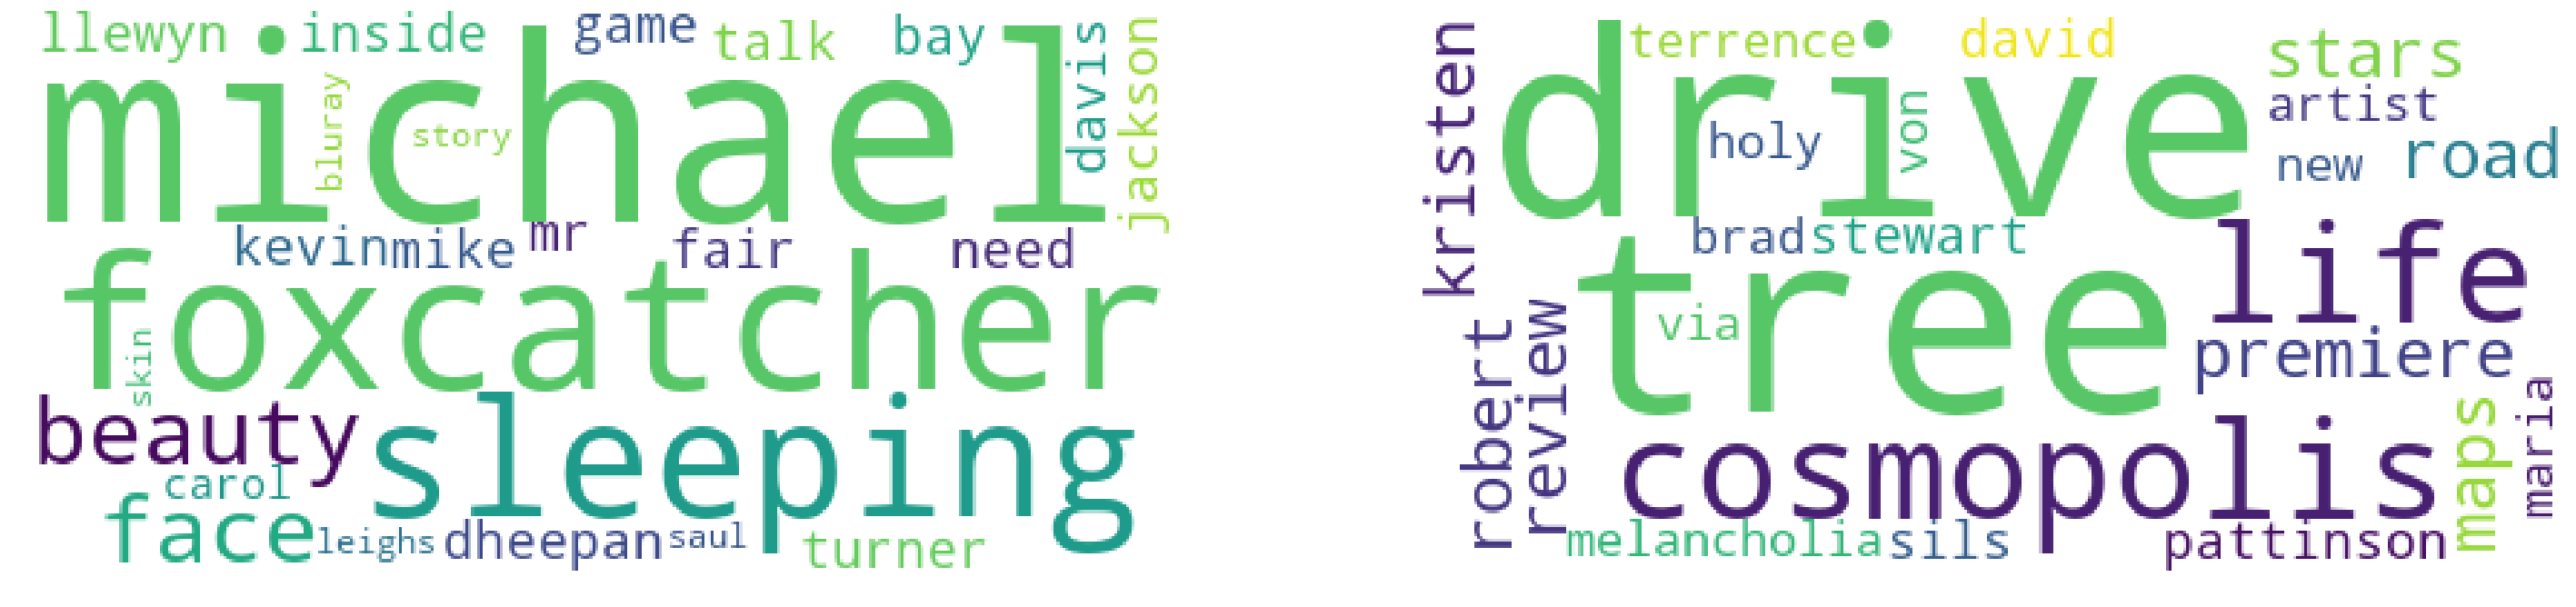

In [7]:
#we use WordCloud to generate the images
from wordcloud import WordCloud

#These are the most frequest words in the tweets corresponding to winning files and losing films separately
#They are generated during cleaning the data, and the code can be found in "DataProcess.py"
win_words = ['michael', 'foxcatcher', 'sleeping', 'beauty', 'face', 'dheepan', 'llewyn', 'kevin', 'turner', 'mr', 'talk', 'need', 'davis', 'bay', 'inside', 'jackson', 'mike', 'fair', 'game', 'carol', 'leighs', 'skin', 'bluray', 'story', 'saul']
win_str = ' '.join(win_words)
lose_words = ['drive', 'tree', 'cosmopolis', 'life', 'premiere', 'road', 'stars', 'robert', 'review', 'kristen', 'maps', 'pattinson', 'david', 'sils', '2012', 'stewart', 'melancholia', 'terrence', 'new', 'artist', 'brad', 'maria', 'via', 'holy', 'von']
lose_str = ' '.join(lose_words)

#generate word cloud. (use lose_str for loser_cloud)
wc = WordCloud(background_color="white", max_words=1000,max_font_size=90, random_state=42)
wl = WordCloud(background_color="white", max_words=1000,max_font_size=90, random_state=42)

# generate word cloud
wc.generate(win_str)
wl.generate(lose_str)

#plot the images, left is the 
fig=plt.figure(figsize=(50, 50))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(wc)
plt.axis("off")
fig.add_subplot(rows, columns, 2)
plt.imshow(wl)
plt.axis("off")
plt.show()

We present two hot words cloud: winner words(left) and loser words(right). 

All the words in the cloud are movie-related. For example, in the winner cloud, we easily spot "Drive", which is a 2011 competition film that won the Best Directory Award; Also, "tree" and "life" comes from the movie - "The Tree of Life", which brought home the Palme d'Or in 2011. In the loser cloud, we see "sleeping" and "beauty", which makes up the name of "Sleeping Beauty", another competition film from 2011. While these words are closely related to movies, we observe that they are too tightly related to a specific winning or losing film, which makes these words useless for prediction (Another winning film will be very unlikely to be named "Drive" or "The Tree of Life"). As a result, we do not use these words as features.

## 3. Feature Generation

Since we only have approximately 200 films, we need to carefully design our feature in order to minimize overfitting. We use TextBlob(http://textblob.readthedocs.io/en/dev/) to extact the semtiment of the tweets related to a film.



Specifically, we use TextBlob to extract two features of one tweet text:
1. subjectivity: this is a real value in [0,1], where subjectivity < 0.5 denotes this text is objective and subjectivity > 0.5 denotes this text is subjective.
2. polarity: this is a real value in [-1,1], where polarity < 0 means this text is negative; 0 < polarity < 0.2 means this text is neutral; and polarity > 0.2 means this text is positive.




Based on the sentiment analysis of TextBlob, we extract the following features for each film:
1. twitters: total number of tweets that mention this film in the given period of time
2. likes: total number of likes of the tweets
3. retweets: total number of retweets of the tweets
4. avg: average value of polarity of the tweets 
5. subjectivity_avg: average value of subjectivity of the tweets
6. neg/neu/pos_avg, neg/neu/pos_sub, neg/neu/pos_obj: the average, number of subjective tweets, and number of objective tweets of all the tweets that are classified as negative, neutral, or positive.

In [8]:
#here we only demonstrate how we generate features from the data we generateed above
#the full code we use to generate the features can be found in file "FeatureGeneration.py" and "Concatenate.py"

from textblob import TextBlob

#initialize
values = {'twitters':df_clean.shape[0], 'retweets':0, 'likes':0, 'neg_obj':0, 'neg_sub':0,\
          'neu_obj':0, 'neu_sub':0, 'pos_obj':0, 'pos_sub':0}
pos_avg = 0
neg_avg = 0
neu_avg = 0
avg = 0
sub_avg = 0

for i, row in df_clean.iterrows():
    #get the TextBlob analysis
    analysis = TextBlob(row['text'])
    
    #calculate the subjectivity label
    if(analysis.sentiment.subjectivity < 0.5):    #objective
        subjectivity = -1
    else:                                         #subjective
        subjectivity = 1

    values['retweets'] += row['retweets']
    values['likes'] += row['likes']

    avg += analysis.sentiment.polarity
    sub_avg += analysis.sentiment.subjectivity

    #accumulate the value for each class
    if analysis.sentiment.polarity >= 0.2:    #positive
        pos_avg += analysis.sentiment.polarity
        if subjectivity == 1:
            values['pos_sub'] += 1
        else:
            values['pos_obj'] += 1
    if analysis.sentiment.polarity >= 0:     #neutral
        neu_avg += analysis.sentiment.polarity
        if subjectivity == 1:
            values['neu_sub'] += 1
        else:
            values['neu_obj'] += 1
    if analysis.sentiment.polarity < 0:     #negative
        neg_avg += analysis.sentiment.polarity
        if subjectivity == 1:
            values['neg_sub'] += 1
        else:
            values['neg_obj'] += 1
            
#calculate the average
values['pos_avg'] = pos_avg / df_clean.shape[0]
values['neu_avg'] = neu_avg / df_clean.shape[0]
values['neg_avg'] = neg_avg / df_clean.shape[0]
values['avg'] = avg / df_clean.shape[0]
values['subjectivity_avg'] = sub_avg / df_clean.shape[0]

#construct the dataframe
feature = pd.DataFrame([values])
print(feature)

        avg  likes   neg_avg  neg_obj  neg_sub   neu_avg  neu_obj  neu_sub  \
0  0.150994   6555 -0.015489       34       33  0.166483      684      298   

    pos_avg  pos_obj  pos_sub  retweets  subjectivity_avg  twitters  
0  0.152096      124      266      1701           0.30082      1049  


We calculate this data for each film and put them together to generate the final dataset.
The final dataset consists of training dataset, which is the data from year 2008 to 2017, and test dataset, which is the data of year 2018. Our goal is to classify the test data based on the training data.



## 4. Training Model and Prediction

### 4.1 Split Data

We collect tweets from 2008 to 2018 and our goal is to use tweets from 2008 to 2017 as training data and predict the Cannes Film Festival winners based on the 2018 tweets. The training data is splitted into sub_training and sub_test data set in order to evaluate our model performance. We carry out cross validation on the sub_training to select our model hyper-parameters. The splitting structure is as follows(variable names are in the square brackets):

    -- Test data (2018 twitters) [X_test_]
    -- Training data (2008-2017 twitters) [X_train_ and y_train_]
        - Sub_test data (30% of training data) [X_train and y_train]
        - Sub_training data (70% of training data) --> cross validation [X_test and y_test]

In [13]:
X_train_ = pd.read_csv('data/values/train_X.csv')
y_train_ = pd.read_csv('data/values/train_y.csv')
X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size = 0.3, random_state=0)
X_train.to_csv('data/values/sub_train_X.csv', index=False)
y_train.to_csv('data/values/sub_train_y.csv', index=False)
X_test.to_csv('data/values/sub_test_X.csv', index=False)
y_test.to_csv('data/values/sub_test_y.csv', index=False)

### 4.2 Read Data

In [14]:
X_test_ = pd.read_csv('data/values/test.csv')
X_train_ = pd.read_csv('data/values/train_X.csv')
y_train_ = pd.read_csv('data/values/train_y.csv')
X_train_ = X_train_.interpolate()
X_test_ = X_test_.interpolate()

X_train = pd.read_csv('data/values/sub_train_X.csv')
y_train = pd.read_csv('data/values/sub_train_y.csv', index_col= False)
X_test = pd.read_csv('data/values/sub_test_X.csv')
y_test = pd.read_csv('data/values/sub_test_y.csv')
X_train = X_train.interpolate()
X_test = X_test.interpolate()

### 4.3 Model Selection Based on Accuracy Score

In this section, we first demonstrate how to carry out model selection via cross validation based on accuracy score. We later discover that, since our twitter data is imbalanced, accuracy score is not a good measurement model performance (it may predict all films as losers to achieve highest accuracy score). In the next section, we turn to Receiver Operating Characteristic curve (ROC) for help. Now, we give an example of our result based on accuracy score.

We select hyper-parameters using cross validation in the X_train/y_train dataset and then look at our test score on X_test/y_test. We use Quadratic Discriminant Analysis as the model in this example. It can be seen that we observed only 4 films are classified as winners, while we want to predict 6 films that are likely to win.

In [15]:
dropping = []
thresh = 3

list18 = ['At War', 'Asako I & II', 'Ash Is Purest White', 'Burning', 'Capernaum', 'BlacKkKlansman', 'Cold War',\
'Dogman', 'Everybody Knows', 'Girls of the Sun', 'Happy as Lazzaro', 'The Image Book', 'Knife + Heart', 'The Little One',\
'Shoplifters', 'Sorry Angel', 'Summer', 'Three Faces', 'Under the Silver Lake', 'The Wild Pear Tree', 'Yomeddine']

def generate(fname):
    x = pd.read_csv(fname)
    x.interpolate(inplace=True)
    if x.shape[1] == 1:
        return x.values.flatten()
    if len(dropping) > 0:
        for d in dropping:
            x = x.drop(x.columns[d], axis=1)
        return x.values

    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(x.values, ix) for ix in range(x.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            dropped = True
            print("dropping " + list(x)[maxloc])
            x = x.drop(x.columns[maxloc], axis=1)
            dropping.append(maxloc)

    return x.values

def train(reg, t, sc, x, y, xp, yp):
    classifier = QuadraticDiscriminantAnalysis(reg_param=reg, tol=t, store_covariance=sc)
    classifier.fit(x, y)
    y_out = classifier.predict(xp)
    err = (y_out == yp).mean()
    return err

In [16]:
x_tr = generate("data/values/train_X.csv")
y_tr = generate("data/values/train_y.csv")
x_str = generate("data/values/sub_train_X.csv")
x_ste = generate("data/values/sub_test_X.csv")
y_str = generate("data/values/sub_train_y.csv")
y_ste = generate("data/values/sub_test_y.csv")
x = generate("data/values/test.csv")

min_err = float('inf')
min_reg = None
min_t = None
min_sc = None
for sc in [True, False]:
    for t in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1]:
        for reg in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]:
                err = train(reg, t, sc, x_str, y_str, x_ste, y_ste)
                if err < min_err:
                    min_t = t
                    min_reg = reg
                    min_sc = sc
                    min_err = err


classifier = QuadraticDiscriminantAnalysis(reg_param=min_reg, tol=min_t, store_covariance=min_sc)
classifier.fit(x_tr, y_tr)
y_out = classifier.predict(x)

print("Test score: ", 1 - min_err)
print()
print("predicted label: ")
print(y_out)
print()
place = np.where(y_out == 1)[0]
print("predictions:")
i=1
for p in place:
    print("- film %d: " % i , list18[p])
    i += 1

dropping twitters
dropping pos_avg
dropping pos_sub
dropping likes
dropping subjectivity_avg
dropping neu_obj
dropping pos_obj
dropping neg_sub
Test score:  0.6166666666666667

predicted label: 
[-1 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1]

predictions:
- film 1:  BlacKkKlansman
- film 2:  Girls of the Sun
- film 3:  The Image Book
- film 4:  Under the Silver Lake


It can be seen that only 4 films are classified as winner, which is not what we desired.

### 4.4 Model Selection Based on ROC

Since the models using accuracy score fail to meet our expectations, we turn to ROC curve for evaluating our model performance. A general description of ROC curve is as follows:

Given a threshold, we can get a confusion matrix like this:

| True/Estimation | 1| -1|
|-----------------|--|---|
|           1     | TP | FN  |
|          -1     | FP| TN |

We can calculate: TPR = TP / (TP + FN) and FPR = FP / (FP + TN) and then plot TRP vs FPR, which is the ROC curve.

The y-axis represents sensitivity: the fraction of true that correctly identifies as true.

The x-axis is (100%-Specificity), in which specificity is the fraction of false that correctly identifies as false.

The area between the x-axis and the ROC curve (AUC) is roughly a measurement of how well our model performs. We will get 0.5 AUC score to represent random guess.

In this section, we perform cross-validation and grid search for hyper-parameters in our model based on the area under curve (AUC) score.

#### Cross-validation based on ROC

In [17]:
# Run classifier with cross-validation and plot ROC curves
def ROC_CV(clf, X, y, verbose = False, n_splits = 6, **params):   
    cv = StratifiedKFold(n_splits=n_splits)
    classifier = clf
    classifier.set_params(**params)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        classifier.fit(X[train], y[train])

        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        if verbose == True:
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    if verbose == True:
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    if verbose == True:
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

    return mean_auc

#### Grid search based on ROC:

In [18]:
def ROC_GS(clf, X, y, params, n_splits = 6):
    
    def custom_score(ground_truth, predictions):
        fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)
        return auc(fpr, tpr)

    my_auc = make_scorer(custom_score, greater_is_better=True, needs_proba=True)
    
    grid_cv = GridSearchCV(clf, param_grid = params, scoring = my_auc, cv = StratifiedKFold(n_splits=n_splits))
    grid_cv.fit(X, y)

    clf_best = grid_cv.best_estimator_
    score_best = grid_cv.best_score_
    param_best = grid_cv.best_params_

    return (clf_best, score_best, param_best)

### 4.5 Model Selection

To calculate ROC and AUC, a model must be able to predict the probability of being each class instead of only the class label. Here we present 7 models and calculate the AUC of each of them. These models in order are: logistic regression, Quadratic Discriminant Analysis, Linear discriminant Analysis, Random Forest, Gradient Boosting Ensemble, K-Nearest Neighbors, Gaussian Process.

#### Logistic Regression

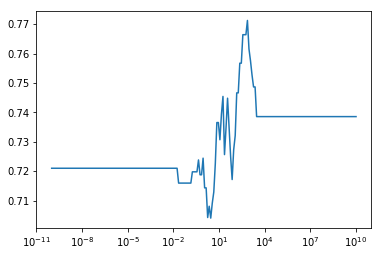

test roc for cross-validation:  0.6290115532734275
test roc for default parameters setting:  0.5866495507060334


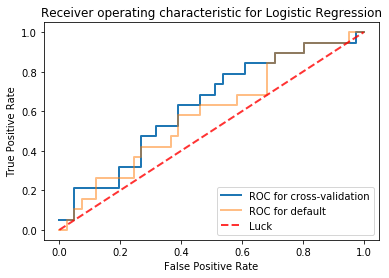

In [19]:
clf = LogisticRegression(random_state=0)
params = np.logspace(-10, 10, 200)
lst_roc = []
for C in params:
    res = ROC_CV(clf, X_train.values, y_train.values.ravel(), n_splits=25, C=C, class_weight='balanced')
    lst_roc.append(res)

plt.plot(params, lst_roc)
plt.xscale('log')
plt.show()
best_param = params[np.array(lst_roc).argmax()]
best_clf = LogisticRegression(C=best_param, random_state=0)
best_clf.fit(X_train.values, y_train.values.ravel())
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, best_clf.predict_proba(X_test.values)[:,1])
roc_auc_best = auc(fpr_best, tpr_best)
plt.plot(fpr_best, tpr_best, lw=2,
                     label='ROC for cross-validation')
print("test roc for cross-validation: ", roc_auc_best)

default_clf = LogisticRegression(random_state=0)
default_clf.fit(X_train.values, y_train.values.ravel())
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, default_clf.predict_proba(X_test.values)[:,1])
roc_auc_default = auc(fpr_default, tpr_default)
plt.plot(fpr_default, tpr_default, lw=2, alpha=0.5,
                     label='ROC for default')
print("test roc for default parameters setting: ", roc_auc_default)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

best_clf.fit(X_train_, y_train_.values.ravel())
pred_prob_lr = best_clf.predict_proba(X_test_)
auc_lr = roc_auc_best

#### Quadratic Discriminant Analysis

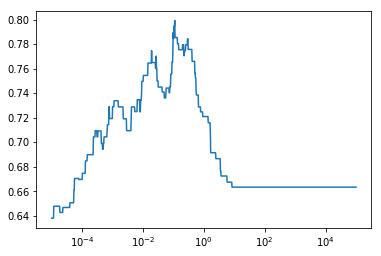

test roc for cross-validation:  0.5340179717586649
test roc for default parameters setting:  0.4801026957637997


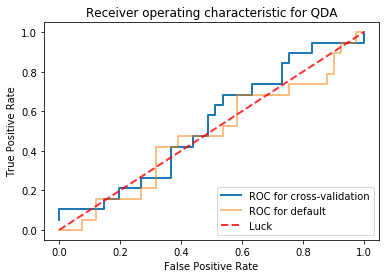

In [20]:
clf = QuadraticDiscriminantAnalysis(tol = 1e-6)
params = np.logspace(-5, 5, 1000)
lst_roc = []
for C in params:
    res = ROC_CV(clf, X_train.values, y_train.values.ravel(), n_splits=25, reg_param = C)
    lst_roc.append(res)

plt.plot(params, lst_roc)
plt.xscale('log')
plt.show()

best_param = params[np.array(lst_roc).argmax()]
best_clf = QuadraticDiscriminantAnalysis(reg_param=best_param, tol = 1e-6)
best_clf.fit(X_train.values, y_train.values.ravel())
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, best_clf.predict_proba(X_test.values)[:,1])
roc_auc_best = auc(fpr_best, tpr_best)
plt.plot(fpr_best, tpr_best, lw=2,
                     label='ROC for cross-validation')
print("test roc for cross-validation: ", roc_auc_best)

default_clf = QuadraticDiscriminantAnalysis()
default_clf.fit(X_train.values, y_train.values.ravel())
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, default_clf.predict_proba(X_test.values)[:,1])
roc_auc_default = auc(fpr_default, tpr_default)
plt.plot(fpr_default, tpr_default, lw=2, alpha=0.5,
                     label='ROC for default')
print("test roc for default parameters setting: ", roc_auc_default)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for QDA')
plt.legend(loc="lower right")
plt.show()

best_clf.fit(X_train_, y_train_.values.ravel())
pred_prob_qda = best_clf.predict_proba(X_test_)

#### Linear Discriminant Analysis

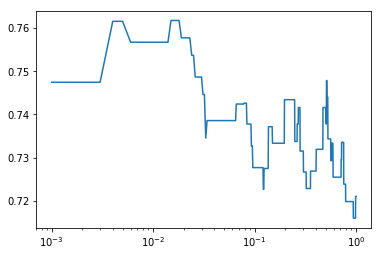

test roc for cross-validation:  0.6585365853658536
test roc for default parameters setting:  0.6559691912708601


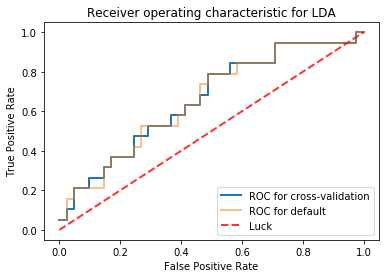

In [21]:
clf = LinearDiscriminantAnalysis()
params = np.arange(0,1,0.001)
lst_roc = []
for C in params:
    res = ROC_CV(clf, X_train.values, y_train.values.ravel(), n_splits=25, solver = 'lsqr', shrinkage = C)
    lst_roc.append(res)

plt.plot(params, lst_roc)
plt.xscale('log')
plt.show()
best_param = params[np.array(lst_roc).argmax()]
best_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_param)
best_clf.fit(X_train.values, y_train.values.ravel())
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, best_clf.predict_proba(X_test.values)[:,1])
roc_auc_best = auc(fpr_best, tpr_best)
plt.plot(fpr_best, tpr_best, lw=2,
                     label='ROC for cross-validation')
print("test roc for cross-validation: ", roc_auc_best)

default_clf = LinearDiscriminantAnalysis()
default_clf.fit(X_train.values, y_train.values.ravel())
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, default_clf.predict_proba(X_test.values)[:,1])
roc_auc_default = auc(fpr_default, tpr_default)
plt.plot(fpr_default, tpr_default, lw=2, alpha=0.5,
                     label='ROC for default')
print("test roc for default parameters setting: ", roc_auc_default)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for LDA')
plt.legend(loc="lower right")
plt.show()

best_clf.fit(X_train_, y_train_.values.ravel())
pred_prob_lda = best_clf.predict_proba(X_test_)
auc_lda = roc_auc_best

#### Random Forest

best parameters:  {'max_depth': 2, 'n_estimators': 240}
test roc for cross-validation:  0.527599486521181
test roc for default parameters setting:  0.5481386392811296


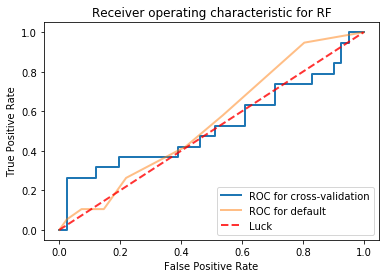

In [22]:
clf = RandomForestClassifier(random_state=0)
params = {'n_estimators': np.arange(100,300,20), 'max_depth': np.arange(1,5,1) }

(best_clf, score_best, best_param) = ROC_GS(clf, X_train.values, y_train.values.ravel(), params, n_splits = 25)
print("best parameters: ", best_param)

fpr_best, tpr_best, thresholds_best = roc_curve(y_test, best_clf.predict_proba(X_test.values)[:,1])
roc_auc_best = auc(fpr_best, tpr_best)
plt.plot(fpr_best, tpr_best, lw=2,
                     label='ROC for cross-validation')
print("test roc for cross-validation: ", roc_auc_best)

default_clf = RandomForestClassifier(random_state=0)
default_clf.fit(X_train.values, y_train.values.ravel())
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, default_clf.predict_proba(X_test.values)[:,1])
roc_auc_default = auc(fpr_default, tpr_default)
plt.plot(fpr_default, tpr_default, lw=2, alpha=0.5,
                     label='ROC for default')
print("test roc for default parameters setting: ", roc_auc_default)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for RF')
plt.legend(loc="lower right")
plt.show()

#### Gradient Boosting 

best parameters:  {'learning_rate': 0.054286754393238594, 'max_depth': 3, 'n_estimators': 50}
test roc for cross-validation:  0.4621309370988447
test roc for default parameters setting:  0.47111681643132214


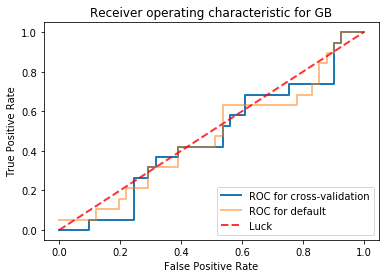

In [23]:
clf = GradientBoostingClassifier(random_state=0)
params = {'learning_rate': np.logspace(-2, 2, 50), 
          'n_estimators': np.arange(50,150,50), 
          'max_depth': [3] }

(best_clf, score_best, best_param) = ROC_GS(clf, X_train.values, y_train.values.ravel(), params, n_splits = 25)
print("best parameters: ", best_param)

fpr_best, tpr_best, thresholds_best = roc_curve(y_test, best_clf.predict_proba(X_test.values)[:,1])
roc_auc_best = auc(fpr_best, tpr_best)
plt.plot(fpr_best, tpr_best, lw=2,
                     label='ROC for cross-validation')
print("test roc for cross-validation: ", roc_auc_best)

default_clf = GradientBoostingClassifier(random_state=0)
default_clf.fit(X_train.values, y_train.values.ravel())
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, default_clf.predict_proba(X_test.values)[:,1])
roc_auc_default = auc(fpr_default, tpr_default)
plt.plot(fpr_default, tpr_default, lw=2, alpha=0.5,
                     label='ROC for default')
print("test roc for default parameters setting: ", roc_auc_default)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for GB')
plt.legend(loc="lower right")
plt.show()

#### K Nearest Neighbours

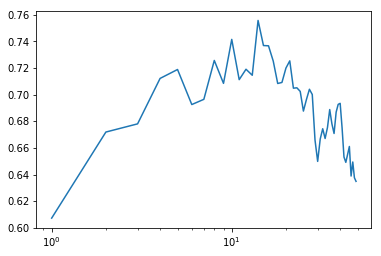

test roc for cross-validation:  0.6123234916559692
test roc for default parameters setting:  0.5718870346598203


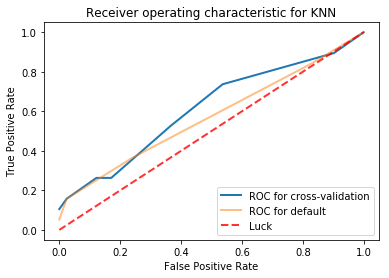

In [27]:
clf = KNeighborsClassifier()
params = np.arange(1,50,1)
lst_roc = []
for C in params:
    res = ROC_CV(clf, X_train.values, y_train.values.ravel(), n_splits=30, n_neighbors=C)
    lst_roc.append(res)

plt.plot(params, lst_roc)
plt.xscale('log')
plt.show()
best_param = params[np.array(lst_roc).argmax()]
best_clf = KNeighborsClassifier(n_neighbors=best_param)
best_clf.fit(X_train.values, y_train.values.ravel())
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, best_clf.predict_proba(X_test.values)[:,1])
roc_auc_best = auc(fpr_best, tpr_best)
plt.plot(fpr_best, tpr_best, lw=2,
                     label='ROC for cross-validation')
print("test roc for cross-validation: ", roc_auc_best)

default_clf = KNeighborsClassifier()
default_clf.fit(X_train.values, y_train.values.ravel())
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, default_clf.predict_proba(X_test.values)[:,1])
roc_auc_default = auc(fpr_default, tpr_default)
plt.plot(fpr_default, tpr_default, lw=2, alpha=0.5,
                     label='ROC for default')
print("test roc for default parameters setting: ", roc_auc_default)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for KNN')
plt.legend(loc="lower right")
plt.show()

best_clf.fit(X_train_, y_train_.values.ravel())
pred_prob_KNN = best_clf.predict_proba(X_test_)
auc_KNN = roc_auc_best

#### Gaussian Process

test roc for default parameters setting:  0.6469833119383825


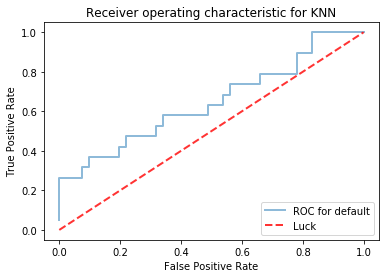

In [28]:
default_clf = GaussianProcessClassifier(random_state=0)
default_clf.fit(X_train.values, y_train.values.ravel())
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, default_clf.predict_proba(X_test.values)[:,1])
roc_auc_default = auc(fpr_default, tpr_default)
plt.plot(fpr_default, tpr_default, lw=2, alpha=0.5,
                     label='ROC for default')
print("test roc for default parameters setting: ", roc_auc_default)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for KNN')
plt.legend(loc="lower right")
plt.show()

best_clf.fit(X_train_, y_train_.values.ravel())
pred_prob_GP = best_clf.predict_proba(X_test_)
auc_GP = roc_auc_default

## 5. Prediction

Now it's time to combine every piece together and make prediction!

We observe above that Logistic Regression, Linear Discriminant Analysis, KNN, Gaussian Process outperform other models. Hence we select these 4 models as our base model and make an ensemble model based on them. The detail is as follows:

●	For each model, we get the predicted probability of each nominated film winning an award

●	We calculate the weighted average of each film's probability using these 4 models. The weight is their respective auc score.

●	We select the top 6 films with highest probability as our final prediction.


In [29]:
df_pred_lr = pd.DataFrame(pred_prob_lr)
df_pred_lda = pd.DataFrame(pred_prob_lda)
df_pred_KNN = pd.DataFrame(pred_prob_KNN)
df_pred_GP = pd.DataFrame(pred_prob_GP)

In [30]:
df_pred = pd.DataFrame()
df_pred['lr'] = df_pred_lr[1]
df_pred['lda'] = df_pred_lda[1]
df_pred['knn'] = df_pred_KNN[1]
df_pred['gp'] = df_pred_GP[1]
df_pred['final_prob'] = df_pred.apply(lambda row: (row.lr * auc_lr +
                                      row.lda * auc_lda + row.knn * auc_KNN + row.gp * auc_GP)
                                      / (auc_lr + auc_lda + auc_KNN + auc_GP), axis=1)

In [31]:
lst_films = ['At War', 'Asako I & II', 'Ash Is Purest White', 'Burning', 'Capernaum', 'BlacKkKlansman', 'Cold War','Dogman', 'Everybody Knows', 'Girls of the Sun', 'Happy as Lazzaro', 'The Image Book', 'Knife + Heart', 'The Little One',\
'Shoplifters', 'Sorry Angel', 'Summer', 'Three Faces', 'Under the Silver Lake', 'The Wild Pear Tree', 'Yomeddine']
print("Top 6 most-likely-winners are: ")
idx = np.array(df_pred.sort_values(by = 'final_prob' , ascending=False).iloc[:6,-1].index)
films = np.array(lst_films)
films_award = films[idx]
for i in range(len(films_award)):
    print("- film %d: " % (i+1), films_award[i])

Top 6 most-likely-winners are: 
- film 1:  Summer
- film 2:  Asako I & II
- film 3:  Dogman
- film 4:  Shoplifters
- film 5:  Happy as Lazzaro
- film 6:  The Image Book


The 2018 Cannes Festival has started and will end on May 19. Let's see if our prediction matches the outcome!

## 6. Further Directions

Considering the time scope of this project, we understand that there are limitations to our data analysis and machine learning pipeline. We suggest the following ideas for future improvements:

1.  Currently, we observe that our signature words set is clouded by specific movie or people’s name. We believe it would be a good idea to analyze the part of speech of each tweet and keep only adjectives before creating a counter for winning and losing groups, respectively. After this, we can use these words to create One-Hot-Encoder features for further analysis.

3. Instead of treating all awards in the same way, we can process data differently according to the award to make more directed predictions. For example, if we are trying to predict the "Best Actor" award, we can collect more tweets that mentions those actors.

### Related links:
[1] Cannes Festival 2018: https://www.festival-cannes.com/en/festival/

[2] GetOldTweets: https://github.com/Jefferson-Henrique/GetOldTweets-python

[3] WordCloud: https://github.com/amueller/word_cloud

[4] TextBlob: http://textblob.readthedocs.io/en/dev/

[5] Twitter Sentiment Analysis: https://github.com/manan904/Twitter-Sentiment-Analysis